# 베타 계산




In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/jimsjoo/gilbut_portfolio/master/portfolioAB.csv')

In [4]:
import math

In [6]:
returns = df[['KOSPI', 'PortA', 'PortB']].pct_change()

In [7]:
vol_m = returns['KOSPI'].std() * math.sqrt(250)
vol_A = returns['PortA'].std() * math.sqrt(250)
vol_B = returns['PortB'].std() * math.sqrt(250)

print('KOSPI 변동성: {:0.2%}'.format(vol_m))
print('PortA 변동성: {:0.2%}'.format(vol_A))
print('PortB 변동성: {:0.2%}'.format(vol_B))

KOSPI 변동성: 9.83%
PortA 변동성: 4.15%
PortB 변동성: 4.76%


In [8]:
covs = returns.cov()
cov_mA = covs.loc['KOSPI', 'PortA']
cov_mB = covs.loc['KOSPI', 'PortB']

var_m = returns['KOSPI'].var()

beta_A = cov_mA / var_m
beta_B = cov_mB / var_m

print('Portfolio A의 beta: {:.4f}'.format(beta_A))
print('Portfolio B의 beta: {:.4f}'.format(beta_B))

Portfolio A의 beta: 0.0154
Portfolio B의 beta: 0.0186


# K-최근접 이웃 알고리즘을 이용한 회귀

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as web
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [4]:
# 주가지수 데이터 가져오기
symbol, source, start, end = 'SPY', 'yahoo', '2016-01-01', '2020-01-01'
df = web.DataReader(symbol, source, start, end)[['Open', 'High', 'Low', 'Close']]

# 예측변수 설정
df = df.dropna()
df['Open-Close'] = df.Open - df.Close
df['High-Low'] = df.High - df.Low
X = df[['Open-Close', 'High-Low']]

# 목표변수 설정
Y = np.where(df['Close'].shift(-1) > df['Close'], +1, -1)

In [5]:
# 데이터셋 분할
train_pct = 0.7
split = int(train_pct*len(df))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

In [9]:
# KNN 모델 설정
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, Y_train)

accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print('Train data Accuracy: %.2f' % accuracy_train)
print('Test data Accuracy: %.2f' % accuracy_test)

Train data Accuracy: 0.59
Test data Accuracy: 0.50


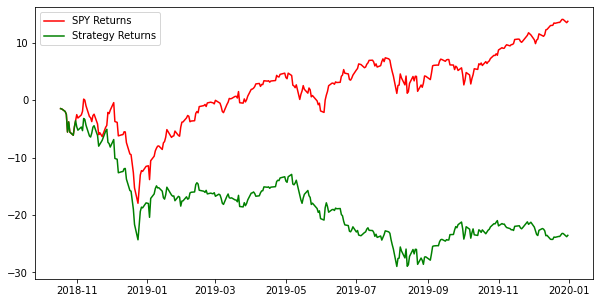

In [10]:
# 모델을 바탕으로 전략 실행
df['Signal'] = knn.predict(X)

# S&P500의 일간수익률
df['SPY_Returns'] = np.log(df['Close']/df['Close'].shift(1))
Cum_SPY_Returns = df[split:]['SPY_Returns'].cumsum() * 100

# 전략의 일간수익률
df['STR_Returns'] = df['SPY_Returns'] * df['Signal'].shift(1)
Cum_STR_Returns = df[split:]['STR_Returns'].cumsum() * 100

plt.figure(figsize=(10, 5))
plt.plot(Cum_SPY_Returns, color='r', label='SPY Returns')
plt.plot(Cum_STR_Returns, color='g', label='Strategy Returns')
plt.legend()
plt.show()

In [11]:
# 샤프비율 계산

Std = Cum_STR_Returns.std()
Sharpe = (Cum_STR_Returns - Cum_SPY_Returns) / Std
Sharpe = Sharpe.mean()
print('Sharpe ratio: %.2f' % Sharpe)

Sharpe ratio: -3.39
